In [37]:
import os
import cv2
import numpy as np
import random
from google.colab import drive
from sklearn.model_selection import train_test_split

In [38]:
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/ML_DRIVE/Assign_5/flowers'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Define the target image size
img_size = (80, 80)

# Initialize lists to store images and their labels
images = []
labels = []
label_map = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}

In [40]:
# Load images from each folder, resize them, and add them to the list
for label_name, label_idx in label_map.items():
    folder_path = os.path.join(data_path, label_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label_idx)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [41]:
# Shuffle and split the dataset into training and test sets (90:10 split)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, shuffle=True)

# Optionally reduce the training set size if resources are limited (1/10 of the original size)
reduce_train_size = True
if reduce_train_size:
    reduce_factor = 5
    reduced_train_size = len(X_train) // reduce_factor
    X_train, y_train = X_train[:reduced_train_size], y_train[:reduced_train_size]



In [42]:
# Convert training and test images to grayscale
X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_train])
X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_test])

print("Training set size (after reduction):", X_train_gray.shape)
print("Test set size:", X_test_gray.shape)

Training set size (after reduction): (777, 80, 80)
Test set size: (432, 80, 80)


In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np


In [44]:
# Assuming X_train_gray, X_test_gray, y_train, y_test were prepared from the previous steps.
# We reshape the images to include the channel dimension as required by CNNs.
X_train_gray = X_train_gray.reshape(-1, 80, 80, 1)  # Adding the channel dimension
X_test_gray = X_test_gray.reshape(-1, 80, 80, 1)

# Normalize pixel values to range [0, 1]
X_train_gray = X_train_gray / 255.0
X_test_gray = X_test_gray / 255.0


In [45]:
def build_cnn_model(conv_kernels, filters, pooling_type="max", activation="relu", fully_connected=1, regularization="dropout_0.1"):
    model = Sequential()

    # Adding convolutional and pooling layers
    for i, kernel_size in enumerate(conv_kernels):
        model.add(Conv2D(filters[i], kernel_size=kernel_size, padding='same', input_shape=(80, 80, 1) if i == 0 else None))

        # Add the specified activation function
        if activation == "relu":
            model.add(ReLU())
        elif activation == "leaky_relu":
            model.add(LeakyReLU(alpha=0.01))
        elif activation == "sigmoid":
            model.add(tf.keras.layers.Activation("sigmoid"))

        # Pooling layer
        if pooling_type == "max":
            model.add(MaxPooling2D(pool_size=(2, 2)))
        elif pooling_type == "average":
            model.add(AveragePooling2D(pool_size=(2, 2)))

        # Apply regularization if specified
        if regularization == "dropout_0.1":
            model.add(Dropout(0.1))
        elif regularization == "dropout_0.25":
            model.add(Dropout(0.25))
        elif regularization == "batch_norm":
            model.add(BatchNormalization())

    # Flatten the feature map
    model.add(Flatten())

    # Add fully connected layers based on specification
    for _ in range(fully_connected):
        model.add(Dense(128, activation='relu'))
        if regularization == "dropout_0.1":
            model.add(Dropout(0.1))
        elif regularization == "dropout_0.25":
            model.add(Dropout(0.25))
        elif regularization == "batch_norm":
            model.add(BatchNormalization())

    # Output layer (5 classes)
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Experiment 1: Vary Convolution Kernel Sizes

In [46]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the configurations for the experiment
configurations = [
    [(3, 3), (3, 3), (3, 3)],    # Three 3x3 kernels
    [(3, 3), (3, 3), (5, 5)],    # Two 3x3 kernels, one 5x5
    [(3, 3), (5, 5), (5, 5)],    # One 3x3 kernel, two 5x5
    [(5, 5), (5, 5), (5, 5)],    # Three 5x5 kernels
]

def build_cnn_model(conv_kernels, filters, pooling_type="max"):
    model = Sequential()

    # Input layer and first convolutional block
    model.add(Conv2D(filters[0], kernel_size=conv_kernels[0],
                     activation='relu', input_shape=(80, 80, 1), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Additional convolutional blocks
    for kernel_size, num_filters in zip(conv_kernels[1:], filters[1:]):
        model.add(Conv2D(num_filters, kernel_size=kernel_size,
                        activation='relu', padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model





In [47]:
def run_experiment(X_train_gray, y_train, X_test_gray, y_test):
    results = []
    history_list = []

    for i, conv_kernels in enumerate(configurations):
        print(f"\nTraining model with configuration {i+1} - Kernel sizes: {conv_kernels}")

        # Build and train model
        model = build_cnn_model(conv_kernels=conv_kernels,
                              filters=[16, 32, 64])

        start_time = time.time()
        history = model.fit(X_train_gray, y_train,
                          epochs=15,
                          validation_split=0.1,
                          batch_size=32,
                          verbose=1)  # Set to 1 to see progress
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)
        print(f"Configuration {i+1} - Test Accuracy: {test_accuracy:.4f}, "
              f"Training Time: {training_time:.2f} seconds")

        # Store results
        results.append({
            "Configuration": f"Config {i+1}: {conv_kernels}",
            "Test Accuracy": test_accuracy,
            "Training Time (seconds)": training_time
        })
        history_list.append(history.history)

    return results, history_list


Training model with configuration 1 - Kernel sizes: [(3, 3), (3, 3), (3, 3)]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.1864 - loss: 1.6525 - val_accuracy: 0.2564 - val_loss: 1.6051
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.2933 - loss: 1.5973 - val_accuracy: 0.3590 - val_loss: 1.5953
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.2869 - loss: 1.5756 - val_accuracy: 0.2949 - val_loss: 1.5686
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.3007 - loss: 1.5503 - val_accuracy: 0.2692 - val_loss: 1.5426
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.3371 - loss: 1.5149 - val_accuracy: 0.2436 - val_loss: 1.5233
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.3834 - loss: 1.4580 - val_accuracy: 0.3590 - val_loss: 1.4657
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.3707 - loss: 1.4162 - val_accuracy: 0.3974 - val_loss: 1.4712
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.4797 - loss: 1.3313 - val_accuracy: 0.

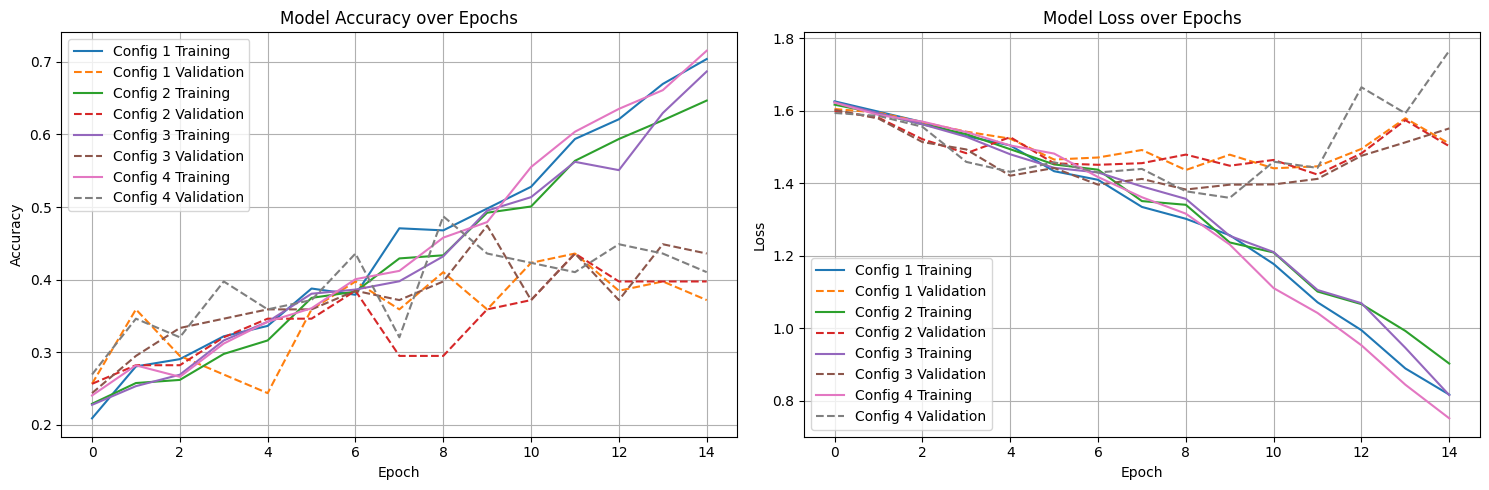

In [48]:
def plot_results(results, history_list):
    # Display results table
    df_results = pd.DataFrame(results)
    table = tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False)
    print("\nSummary of Results:\n", table)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation accuracy
    for i, history in enumerate(history_list):
        ax1.plot(history['accuracy'], label=f'Config {i+1} Training')
        ax1.plot(history['val_accuracy'], linestyle='--',
                label=f'Config {i+1} Validation')

    ax1.set_title('Model Accuracy over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot training and validation loss
    for i, history in enumerate(history_list):
        ax2.plot(history['loss'], label=f'Config {i+1} Training')
        ax2.plot(history['val_loss'], linestyle='--',
                label=f'Config {i+1} Validation')

    ax2.set_title('Model Loss over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Run the experiment
try:
    results, history_list = run_experiment(X_train_gray, y_train, X_test_gray, y_test)
    plot_results(results, history_list)
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Experiment 2: Vary the Number of Fully Connected Layers

 # Task (b): Using 2 and 3 Fully Connected Layers

In [49]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model_with_fc(conv_kernels, filters, num_fc_layers):
    """Build CNN model with varying number of fully connected layers"""
    model = Sequential()

    # First conv layer
    model.add(Conv2D(filters[0], kernel_size=conv_kernels[0],
                     activation='relu', input_shape=(80, 80, 1), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second conv layer
    model.add(Conv2D(filters[1], kernel_size=conv_kernels[1],
                     activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third conv layer
    model.add(Conv2D(filters[2], kernel_size=conv_kernels[2],
                     activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Add fully connected layers
    for _ in range(num_fc_layers):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

def run_fc_experiment(X_train_gray, y_train, X_test_gray, y_test):
    # Best configuration from previous experiment
    best_conv_kernels = [(3, 3), (5, 5), (5, 5)]  # Config 3 from previous results
    results = []
    history_list = []

    # Test different numbers of fully connected layers
    for num_fc_layers in [1, 2, 3]:
        print(f"\nTraining model with {num_fc_layers} fully connected layer(s)")

        # Build model
        model = build_model_with_fc(
            conv_kernels=best_conv_kernels,
            filters=[16, 32, 64],
            num_fc_layers=num_fc_layers
        )

        # Train model and measure time
        start_time = time.time()
        history = model.fit(
            X_train_gray,
            y_train,
            epochs=15,
            validation_split=0.1,
            batch_size=32,
            verbose=1
        )
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

        # Store results
        results.append({
            "FC Layers": num_fc_layers,
            "Test Accuracy": round(test_accuracy, 4),
            "Test Loss": round(test_loss, 4),
            "Training Time (s)": round(training_time, 2),
            "Val Accuracy": round(max(history.history['val_accuracy']), 4),
            "Val Loss": round(min(history.history['val_loss']), 4)
        })

        history_list.append(history.history)

        print(f"Results for {num_fc_layers} FC layer(s):")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")

    return results, history_list




Training model with 1 fully connected layer(s)
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.2216 - loss: 1.6605 - val_accuracy: 0.2308 - val_loss: 1.6043
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.2457 - loss: 1.5956 - val_accuracy: 0.3205 - val_loss: 1.5928
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.2783 - loss: 1.5840 - val_accuracy: 0.3718 - val_loss: 1.5527
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step - accuracy: 0.3182 - loss: 1.5466 - val_accuracy: 0.3718 - val_loss: 1.5059
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.2838 - loss: 1.5104 - val_accuracy: 0.3462 - val_loss: 1.4998
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.3416 - loss: 1.4783 - val_accuracy: 0.4231 - val_loss: 1.5003
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - accuracy: 0.3695 - loss: 1.4575 - val_accuracy: 0.3974 - val_loss: 1.4535
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step

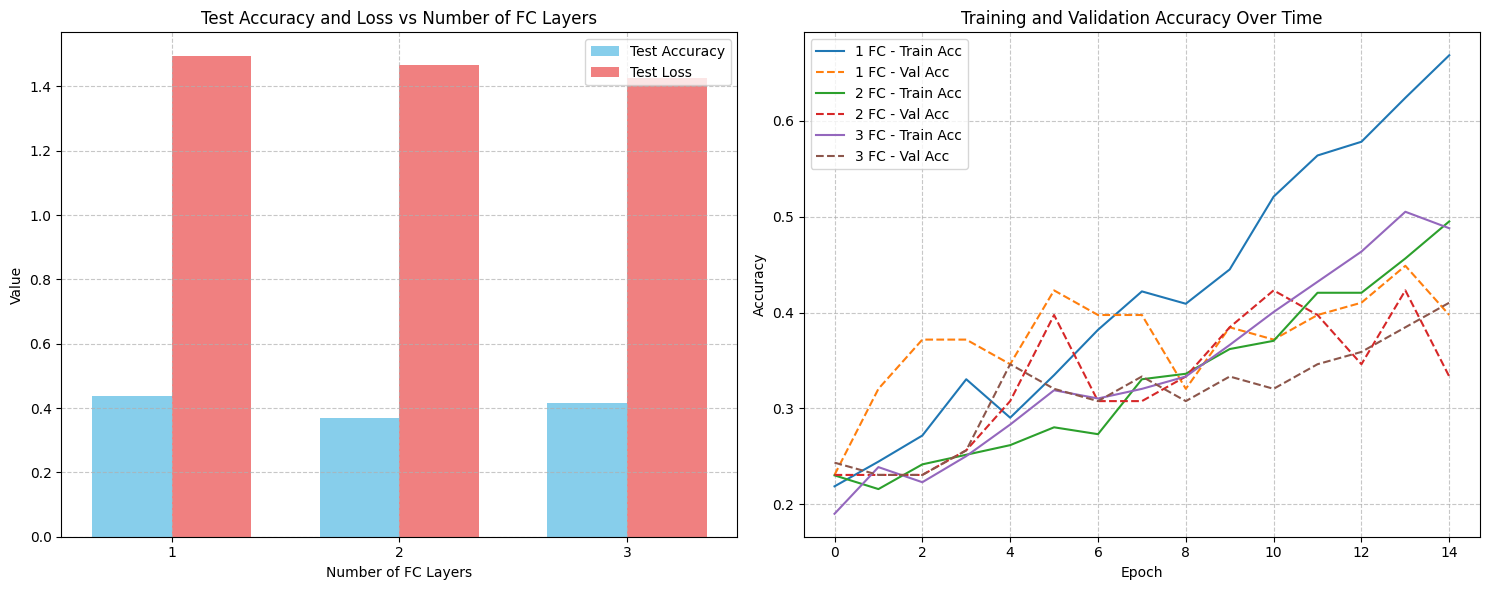

In [50]:
def plot_fc_results(results, history_list):
    # Create DataFrame and display table
    df_results = pd.DataFrame(results)
    table = tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False)
    print("\nFully Connected Layer Experiment Results:\n", table)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Accuracy and Loss Bar Chart
    x = np.arange(len(results))
    width = 0.35

    ax1.bar(x - width/2, [r["Test Accuracy"] for r in results],
            width, label='Test Accuracy', color='skyblue')
    ax1.bar(x + width/2, [r["Test Loss"] for r in results],
            width, label='Test Loss', color='lightcoral')

    ax1.set_xlabel('Number of FC Layers')
    ax1.set_ylabel('Value')
    ax1.set_title('Test Accuracy and Loss vs Number of FC Layers')
    ax1.set_xticks(x)
    ax1.set_xticklabels([r["FC Layers"] for r in results])
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Training History
    for i, history in enumerate(history_list):
        ax2.plot(history['accuracy'],
                label=f'{results[i]["FC Layers"]} FC - Train Acc')
        ax2.plot(history['val_accuracy'], linestyle='--',
                label=f'{results[i]["FC Layers"]} FC - Val Acc')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy Over Time')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Run the experiment
try:
    results, history_list = run_fc_experiment(X_train_gray, y_train, X_test_gray, y_test)
    plot_fc_results(results, history_list)
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Task (c): Use Average Pooling Instead of Max Pooling

In [51]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                   Flatten, Dense, Dropout)
from tensorflow.keras.optimizers import Adam

def build_model_with_pooling(pooling_type='max'):
    """Build CNN model with specified pooling type"""
    model = Sequential()

    # Use the best configuration from previous experiments
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # First conv layer
    model.add(Conv2D(filters[0], kernel_size=conv_kernels[0],
                     activation='relu', input_shape=(80, 80, 1), padding='same'))
    if pooling_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    else:
        model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second conv layer
    model.add(Conv2D(filters[1], kernel_size=conv_kernels[1],
                     activation='relu', padding='same'))
    if pooling_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    else:
        model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third conv layer
    model.add(Conv2D(filters[2], kernel_size=conv_kernels[2],
                     activation='relu', padding='same'))
    if pooling_type == 'max':
        model.add(MaxPooling2D(pool_size=(2, 2)))
    else:
        model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Three fully connected layers (best from previous experiment)
    for _ in range(3):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

def run_pooling_experiment(X_train_gray, y_train, X_test_gray, y_test):
    results = []
    history_list = []

    # Test both pooling types
    for pooling_type in ['max', 'average']:
        print(f"\nTraining model with {pooling_type} pooling")

        # Build and train model
        model = build_model_with_pooling(pooling_type)

        # Train model and measure time
        start_time = time.time()
        history = model.fit(
            X_train_gray,
            y_train,
            epochs=15,
            validation_split=0.1,
            batch_size=32,
            verbose=1
        )
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

        # Store results
        results.append({
            "Pooling Type": pooling_type.capitalize(),
            "Test Accuracy": round(test_accuracy, 4),
            "Test Loss": round(test_loss, 4),
            "Training Time (s)": round(training_time, 2),
            "Best Val Accuracy": round(max(history.history['val_accuracy']), 4),
            "Best Val Loss": round(min(history.history['val_loss']), 4)
        })

        history_list.append(history.history)

        print(f"\nResults for {pooling_type} pooling:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")

    return results, history_list




Training model with max pooling


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.1822 - loss: 1.6280 - val_accuracy: 0.2308 - val_loss: 1.6073
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.2521 - loss: 1.6038 - val_accuracy: 0.2308 - val_loss: 1.6028
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step - accuracy: 0.2496 - loss: 1.5985 - val_accuracy: 0.2308 - val_loss: 1.6020
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - accuracy: 0.2624 - loss: 1.5929 - val_accuracy: 0.2821 - val_loss: 1.5818
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.3163 - loss: 1.5746 - val_accuracy: 0.3205 - val_loss: 1.5328
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.2795 - loss: 1.5670 - val_accuracy: 0.3462 - val_loss: 1.4698
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.3176 - loss: 1.5410 - val_accuracy: 0.2949 - val_loss: 1.5120
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.3829 - loss: 1.4565 - val_accuracy

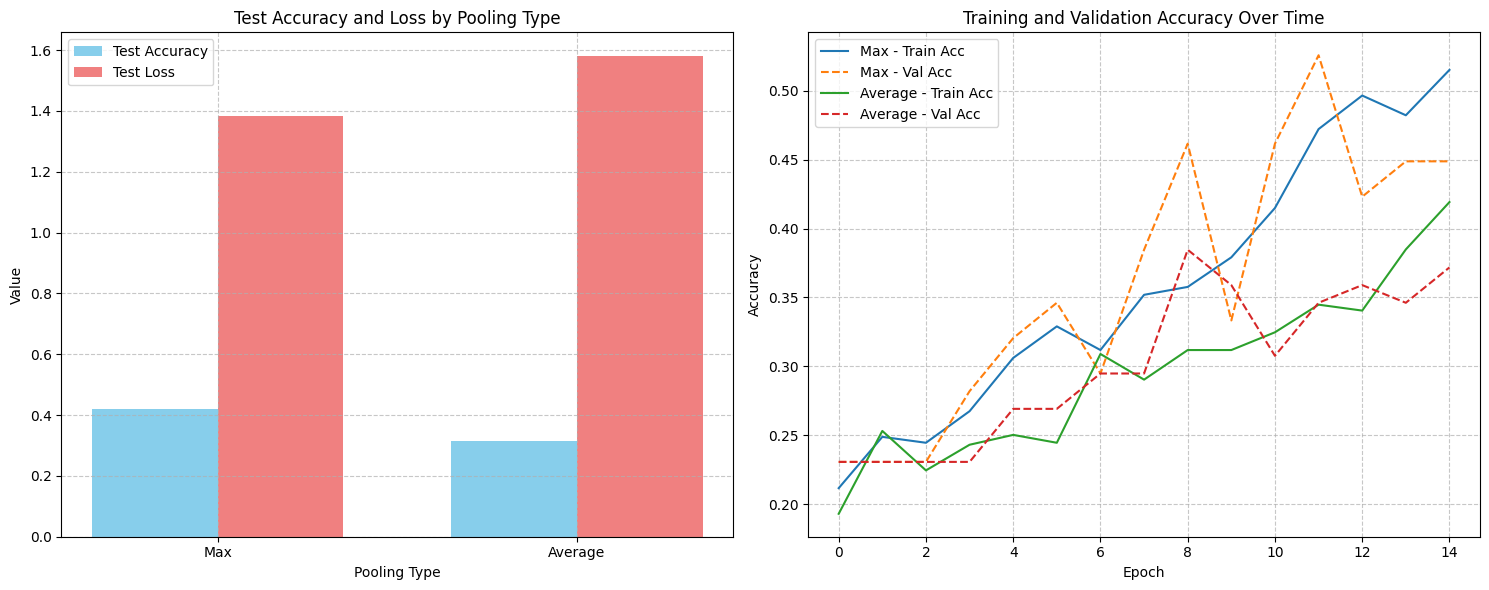

In [52]:
def plot_pooling_results(results, history_list):
    # Display results table
    df_results = pd.DataFrame(results)
    table = tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False)
    print("\nPooling Type Comparison Results:\n", table)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Accuracy and Loss Comparison
    x = np.arange(len(results))
    width = 0.35

    ax1.bar(x - width/2, [r["Test Accuracy"] for r in results],
            width, label='Test Accuracy', color='skyblue')
    ax1.bar(x + width/2, [r["Test Loss"] for r in results],
            width, label='Test Loss', color='lightcoral')

    ax1.set_xlabel('Pooling Type')
    ax1.set_ylabel('Value')
    ax1.set_title('Test Accuracy and Loss by Pooling Type')
    ax1.set_xticks(x)
    ax1.set_xticklabels([r["Pooling Type"] for r in results])
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Training History
    for i, history in enumerate(history_list):
        pooling_type = results[i]["Pooling Type"]
        ax2.plot(history['accuracy'],
                label=f'{pooling_type} - Train Acc')
        ax2.plot(history['val_accuracy'], linestyle='--',
                label=f'{pooling_type} - Val Acc')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy Over Time')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Run the experiment
try:
    results, history_list = run_pooling_experiment(X_train_gray, y_train, X_test_gray, y_test)
    plot_pooling_results(results, history_list)
except Exception as e:
    print(f"An error occurred: {str(e)}")

# Task (d): Vary Activation Functions

In [53]:
# Original Code - Model Training and Evaluation
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, AveragePooling2D, Flatten, Dense,
                                   Dropout, LeakyReLU)
from tensorflow.keras.optimizers import Adam

def build_model_with_activation(activation_type='relu'):
    """Build CNN model with specified activation function"""
    model = Sequential()

    # Best configuration from previous experiments
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # First conv layer
    model.add(Conv2D(filters[0], kernel_size=conv_kernels[0], padding='same',
                     input_shape=(80, 80, 1)))
    if activation_type == "leaky_relu":
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Conv2D(filters[0], kernel_size=conv_kernels[0],
                        activation=activation_type, padding='same',
                        input_shape=(80, 80, 1)))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second conv layer
    model.add(Conv2D(filters[1], kernel_size=conv_kernels[1], padding='same'))
    if activation_type == "leaky_relu":
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Conv2D(filters[1], kernel_size=conv_kernels[1],
                        activation=activation_type, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third conv layer
    model.add(Conv2D(filters[2], kernel_size=conv_kernels[2], padding='same'))
    if activation_type == "leaky_relu":
        model.add(LeakyReLU(alpha=0.01))
    else:
        model.add(Conv2D(filters[2], kernel_size=conv_kernels[2],
                        activation=activation_type, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Three fully connected layers (best from previous experiment)
    for _ in range(3):
        model.add(Dense(128))
        if activation_type == "leaky_relu":
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Dense(128, activation=activation_type))
        model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model




In [54]:
def run_activation_experiment(X_train_gray, y_train, X_test_gray, y_test):
    activations = ["relu", "sigmoid", "leaky_relu"]
    results = []
    history_list = []

    for activation in activations:
        print(f"\nTraining model with {activation} activation function")

        # Build and train model
        model = build_model_with_activation(activation)

        # Train model and measure time
        start_time = time.time()
        history = model.fit(
            X_train_gray,
            y_train,
            epochs=15,
            validation_split=0.1,
            batch_size=32,
            verbose=1
        )
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

        # Store results
        results.append({
            "Activation": activation.upper(),
            "Test Accuracy": round(test_accuracy, 4),
            "Test Loss": round(test_loss, 4),
            "Training Time (s)": round(training_time, 2),
            "Best Val Accuracy": round(max(history.history['val_accuracy']), 4),
            "Best Val Loss": round(min(history.history['val_loss']), 4)
        })

        history_list.append(history.history)

        print(f"\nResults for {activation} activation:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")

    return results, history_list

# Run the experiment
try:
    results, history_list = run_activation_experiment(X_train_gray, y_train,
                                                    X_test_gray, y_test)
except Exception as e:
    print(f"An error occurred: {str(e)}")



Training model with relu activation function


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 994ms/step - accuracy: 0.1932 - loss: 1.6103 - val_accuracy: 0.2308 - val_loss: 1.6047
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 967ms/step - accuracy: 0.2445 - loss: 1.6001 - val_accuracy: 0.2308 - val_loss: 1.6064
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 963ms/step - accuracy: 0.2292 - loss: 1.6011 - val_accuracy: 0.2308 - val_loss: 1.6030
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 994ms/step - accuracy: 0.2444 - loss: 1.6031 - val_accuracy: 0.2308 - val_loss: 1.6029
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 974ms/step - accuracy: 0.2300 - loss: 1.6053 - val_accuracy: 0.2308 - val_loss: 1.6043
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 960ms/step - accuracy: 0.2560 - loss: 1.6007 - val_accuracy: 0.2308 - val_loss: 1.6047
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 966ms/step - accuracy: 0.2621 - loss: 1.5935 - val_accuracy: 0.2308 - val_loss: 1.6030
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 963ms/step - accuracy: 0.2164 - loss: 1.5905 - val_accu

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 452ms/step - accuracy: 0.2187 - loss: 1.6140 - val_accuracy: 0.2308 - val_loss: 1.6031
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.2812 - loss: 1.5990 - val_accuracy: 0.2308 - val_loss: 1.6030
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.2386 - loss: 1.5979 - val_accuracy: 0.2308 - val_loss: 1.5855
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2559 - loss: 1.5819 - val_accuracy: 0.3462 - val_loss: 1.5245
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.2823 - loss: 1.5534 - val_accuracy: 0.3846 - val_loss: 1.5344
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.2994 - loss: 1.5253 - val_accuracy: 0.2949 - val_loss: 1.4678
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.3002 - loss: 1.5047 - val_accuracy: 0.3333 - val_loss: 1.4320
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.3480 - loss: 1.4600 - val_accuracy


Activation Functions Comparison Results:
 ╒══════════════╤═════════════════╤═════════════╤═════════════════════╤═════════════════════╤═════════════════╕
│ Activation   │   Test Accuracy │   Test Loss │   Training Time (s) │   Best Val Accuracy │   Best Val Loss │
╞══════════════╪═════════════════╪═════════════╪═════════════════════╪═════════════════════╪═════════════════╡
│ RELU         │          0.2986 │      1.5881 │              559.27 │              0.2308 │          1.6029 │
├──────────────┼─────────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────────────┤
│ SIGMOID      │          0.2986 │      1.5848 │              580.3  │              0.2308 │          1.6013 │
├──────────────┼─────────────────┼─────────────┼─────────────────────┼─────────────────────┼─────────────────┤
│ LEAKY_RELU   │          0.3889 │      1.5388 │              153.52 │              0.4359 │          1.3963 │
╘══════════════╧═════════════════╧═════════════╧═════════════════════

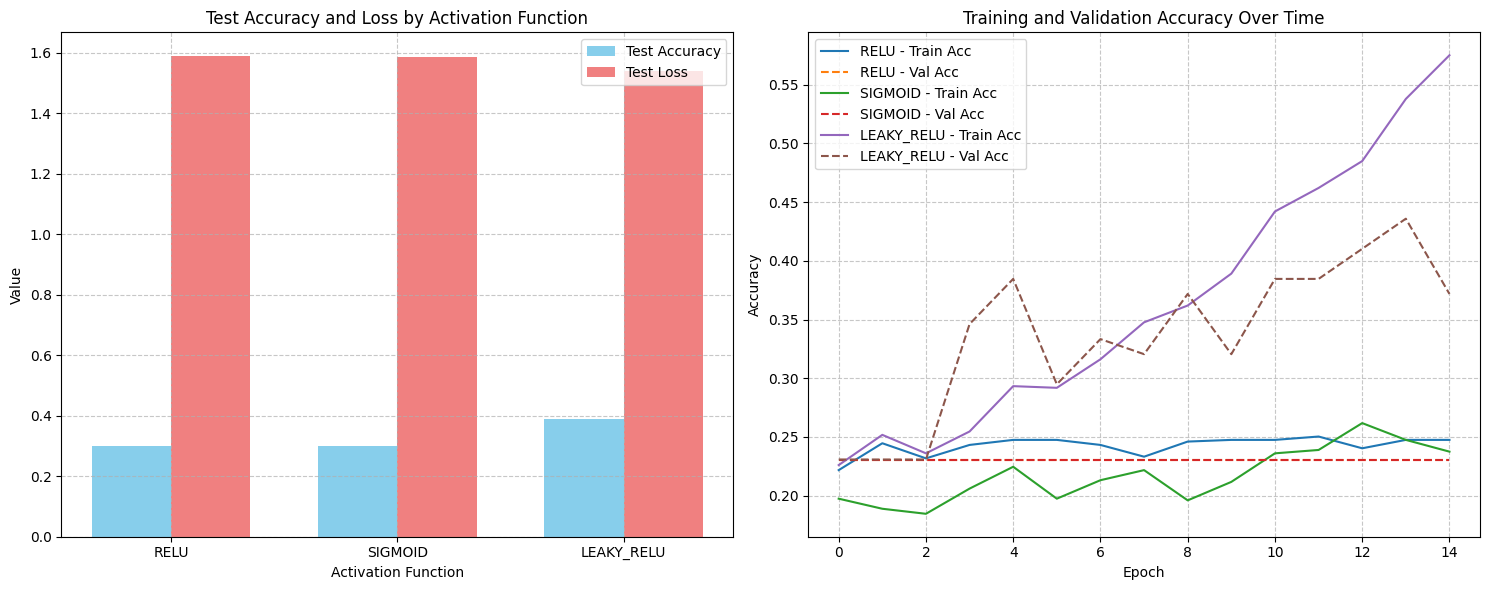

In [55]:
# ******************** Visualization Code ********************

def plot_activation_results(results, history_list):
    # Display results table
    df_results = pd.DataFrame(results)
    table = tabulate(df_results, headers='keys', tablefmt='fancy_grid',
                    showindex=False)
    print("\nActivation Functions Comparison Results:\n", table)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Accuracy and Loss Comparison
    x = np.arange(len(results))
    width = 0.35

    ax1.bar(x - width/2, [r["Test Accuracy"] for r in results],
            width, label='Test Accuracy', color='skyblue')
    ax1.bar(x + width/2, [r["Test Loss"] for r in results],
            width, label='Test Loss', color='lightcoral')

    ax1.set_xlabel('Activation Function')
    ax1.set_ylabel('Value')
    ax1.set_title('Test Accuracy and Loss by Activation Function')
    ax1.set_xticks(x)
    ax1.set_xticklabels([r["Activation"] for r in results])
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Training History
    for i, history in enumerate(history_list):
        activation = results[i]["Activation"]
        ax2.plot(history['accuracy'],
                label=f'{activation} - Train Acc')
        ax2.plot(history['val_accuracy'], linestyle='--',
                label=f'{activation} - Val Acc')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy Over Time')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Generate visualizations
try:
    plot_activation_results(results, history_list)
except Exception as e:
    print(f"An error occurred during visualization: {str(e)}")

In [56]:
# regularization_results = []

# for reg in ["dropout_0.25", "batch_norm", "dropout_0.1_batch_norm"]:
#     print(f"\nTraining model with {reg} regularization...")

#     # Build and compile the model with specified regularization
#     model = build_base_model(regularization=reg)

#     start_time = time.time()
#     history = model.fit(X_train_gray, y_train, epochs=10, validation_split=0.1, batch_size=32, verbose=1)
#     end_time = time.time()
#     training_time = end_time - start_time

#     # Evaluate on test set
#     test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

#     # Append results
#     regularization_results.append((reg, test_accuracy, training_time))
#     print(f"{reg} regularization - Test Accuracy: {test_accuracy}, Training Time: {training_time:.2f} seconds")


In [57]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, AveragePooling2D, Flatten, Dense,
                                   Dropout, LeakyReLU, BatchNormalization)
from tensorflow.keras.optimizers import Adam

# ******************** Model Building and Training Code ********************

def build_model_with_regularization(reg_type='dropout_0.25'):
    """Build CNN model with specified regularization technique"""
    model = Sequential()

    # Configuration from previous best results
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # First conv layer
    model.add(Conv2D(filters[0], kernel_size=conv_kernels[0], padding='same',
                     input_shape=(80, 80, 1)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Add regularization based on type
    if 'dropout' in reg_type:
        dropout_rate = 0.25 if reg_type == 'dropout_0.25' else 0.1
        model.add(Dropout(dropout_rate))
    if 'batch_norm' in reg_type and reg_type != 'dropout_0.25':
        model.add(BatchNormalization())

    # Second conv layer
    model.add(Conv2D(filters[1], kernel_size=conv_kernels[1], padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    if 'dropout' in reg_type:
        dropout_rate = 0.25 if reg_type == 'dropout_0.25' else 0.1
        model.add(Dropout(dropout_rate))
    if 'batch_norm' in reg_type and reg_type != 'dropout_0.25':
        model.add(BatchNormalization())

    # Third conv layer
    model.add(Conv2D(filters[2], kernel_size=conv_kernels[2], padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    if 'dropout' in reg_type:
        dropout_rate = 0.25 if reg_type == 'dropout_0.25' else 0.1
        model.add(Dropout(dropout_rate))
    if 'batch_norm' in reg_type and reg_type != 'dropout_0.25':
        model.add(BatchNormalization())

    # Flatten layer
    model.add(Flatten())

    # Three fully connected layers
    for _ in range(3):
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))

        if 'dropout' in reg_type:
            dropout_rate = 0.25 if reg_type == 'dropout_0.25' else 0.1
            model.add(Dropout(dropout_rate))
        if 'batch_norm' in reg_type and reg_type != 'dropout_0.25':
            model.add(BatchNormalization())

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

def run_regularization_experiment(X_train_gray, y_train, X_test_gray, y_test):
    """Run experiment with different regularization techniques"""
    reg_types = ["dropout_0.25", "batch_norm", "dropout_0.1_batch_norm"]
    results = []
    history_list = []

    for reg_type in reg_types:
        print(f"\nTraining model with {reg_type} regularization")

        # Build and train model
        model = build_model_with_regularization(reg_type)

        # Train model and measure time
        start_time = time.time()
        history = model.fit(
            X_train_gray,
            y_train,
            epochs=15,
            validation_split=0.1,
            batch_size=32,
            verbose=1
        )
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

        # Store results
        results.append({
            "Regularization": reg_type,
            "Test Accuracy": round(test_accuracy, 4),
            "Test Loss": round(test_loss, 4),
            "Training Time (s)": round(training_time, 2),
            "Best Val Accuracy": round(max(history.history['val_accuracy']), 4),
            "Best Val Loss": round(min(history.history['val_loss']), 4)
        })

        history_list.append(history.history)

        print(f"\nResults for {reg_type}:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")

    return results, history_list




Training model with dropout_0.25 regularization


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 413ms/step - accuracy: 0.2094 - loss: 1.6206 - val_accuracy: 0.2308 - val_loss: 1.6070
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.2347 - loss: 1.6068 - val_accuracy: 0.2308 - val_loss: 1.6047
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 417ms/step - accuracy: 0.2148 - loss: 1.6029 - val_accuracy: 0.2308 - val_loss: 1.6035
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - accuracy: 0.2480 - loss: 1.5988 - val_accuracy: 0.2308 - val_loss: 1.5944
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.2354 - loss: 1.5964 - val_accuracy: 0.2308 - val_loss: 1.5655
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 428ms/step - accuracy: 0.2158 - loss: 1.6015 - val_accuracy: 0.2308 - val_loss: 1.5831
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.2867 - loss: 1.5595 - val_accuracy: 0.2692 - val_loss: 1.5419
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.3005 - loss: 1.5378 - val_accuracy

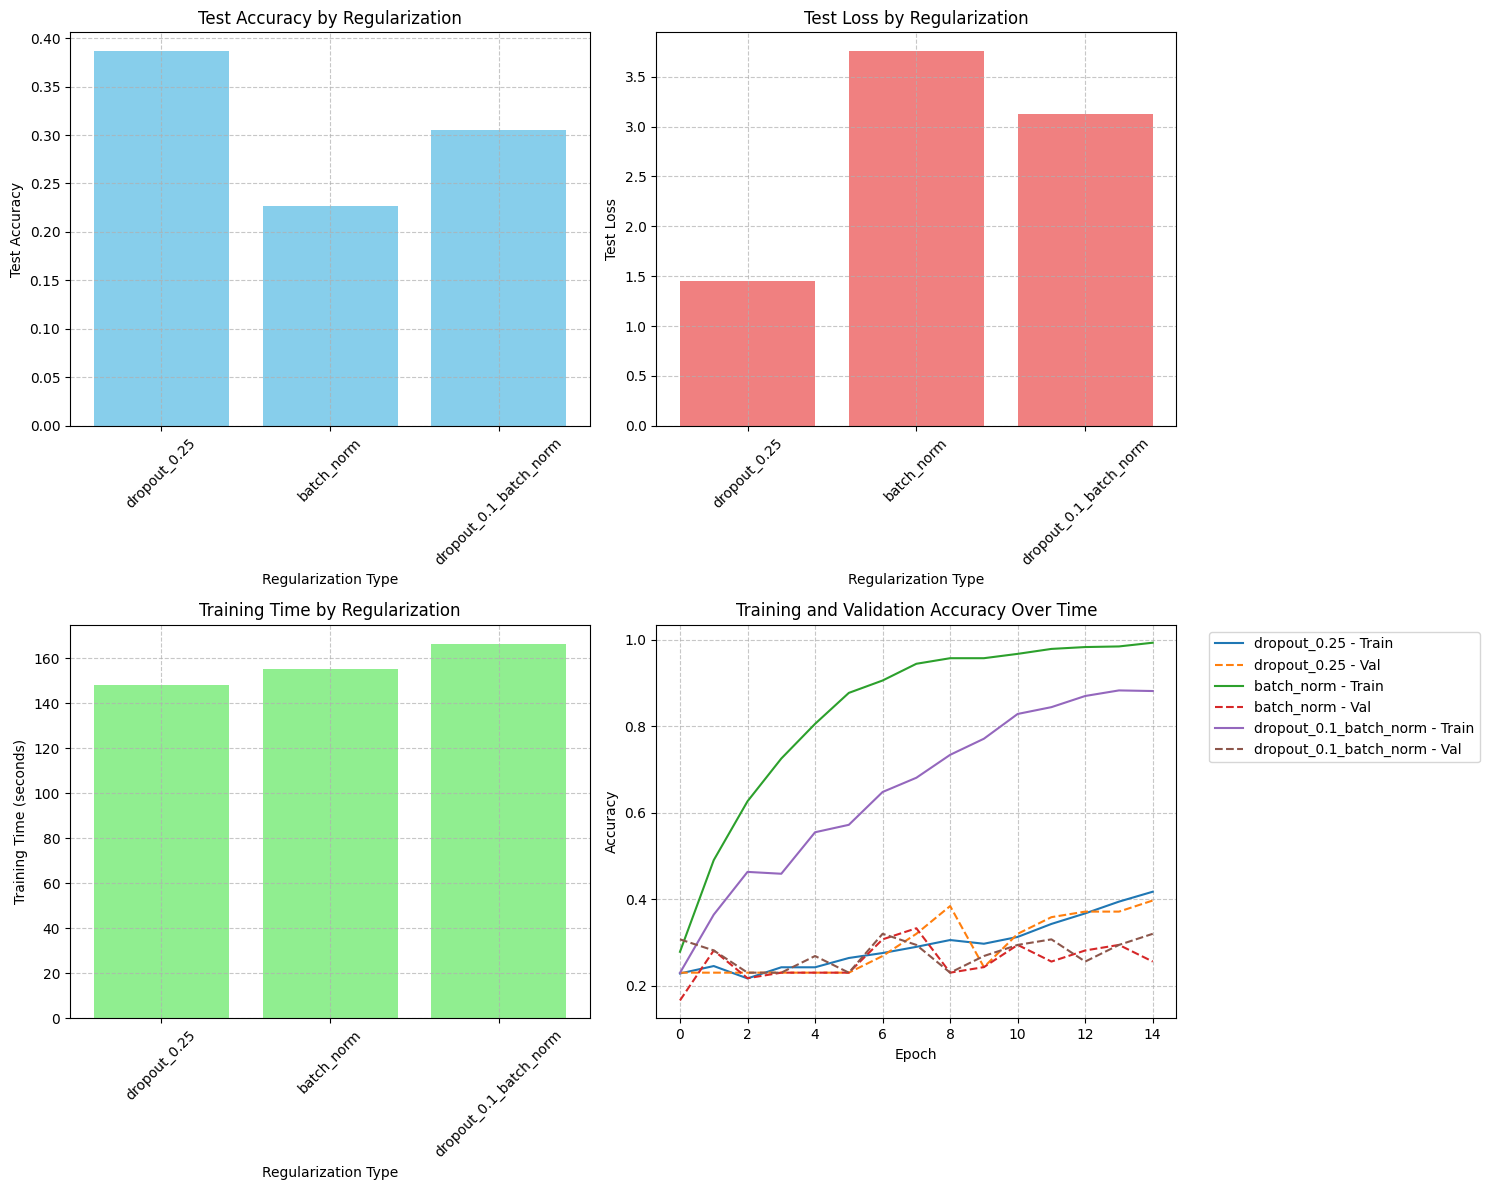

In [58]:
# ******************** Visualization Code ********************

def plot_regularization_results(results, history_list):
    """Generate visualizations for regularization experiment results"""
    # Display results table
    df_results = pd.DataFrame(results)
    table = tabulate(df_results, headers='keys', tablefmt='fancy_grid',
                    showindex=False)
    print("\nRegularization Techniques Comparison:\n", table)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Test Accuracy Comparison
    x = np.arange(len(results))
    ax1.bar(x, [r["Test Accuracy"] for r in results], color='skyblue')
    ax1.set_xlabel('Regularization Type')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title('Test Accuracy by Regularization')
    ax1.set_xticks(x)
    ax1.set_xticklabels([r["Regularization"] for r in results], rotation=45)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Test Loss Comparison
    ax2.bar(x, [r["Test Loss"] for r in results], color='lightcoral')
    ax2.set_xlabel('Regularization Type')
    ax2.set_ylabel('Test Loss')
    ax2.set_title('Test Loss by Regularization')
    ax2.set_xticks(x)
    ax2.set_xticklabels([r["Regularization"] for r in results], rotation=45)
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Training Time Comparison
    ax3.bar(x, [r["Training Time (s)"] for r in results], color='lightgreen')
    ax3.set_xlabel('Regularization Type')
    ax3.set_ylabel('Training Time (seconds)')
    ax3.set_title('Training Time by Regularization')
    ax3.set_xticks(x)
    ax3.set_xticklabels([r["Regularization"] for r in results], rotation=45)
    ax3.grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Training History
    for i, history in enumerate(history_list):
        reg_type = results[i]["Regularization"]
        ax4.plot(history['accuracy'],
                label=f'{reg_type} - Train')
        ax4.plot(history['val_accuracy'], linestyle='--',
                label=f'{reg_type} - Val')

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Training and Validation Accuracy Over Time')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Run the experiment
try:
    results, history_list = run_regularization_experiment(X_train_gray, y_train,
                                                        X_test_gray, y_test)
    plot_regularization_results(results, history_list)
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [59]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, AveragePooling2D, Flatten, Dense,
                                   Dropout, LeakyReLU)
from tensorflow.keras.optimizers import Adam

# ******************** Model Building and Training Code ********************

def build_model_with_extra_layers(extra_layers=0):
    """
    Build CNN model with additional convolutional layers
    Args:
        extra_layers: number of additional conv layers (1, 2, or 3)
    """
    model = Sequential()

    # Base configuration from previous best results
    base_conv_kernels = [(3, 3), (5, 5), (5, 5)]
    base_filters = [16, 32, 64]

    # Additional layers configuration
    # Gradually increase filters while keeping kernel size constant
    extra_kernels = [(3, 3)] * extra_layers
    extra_filters = [min(128 * (2**i), 512) for i in range(extra_layers)]

    all_kernels = base_conv_kernels + extra_kernels
    all_filters = base_filters + extra_filters

    # Input layer
    model.add(Conv2D(all_filters[0], kernel_size=all_kernels[0], padding='same',
                     input_shape=(80, 80, 1)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Additional conv layers
    for i in range(1, len(all_kernels)):
        # Check if we have enough spatial dimensions left
        if model.output_shape[1] <= 2:  # Check height
            print(f"Warning: Stopping at layer {i} due to small spatial dimensions")
            break

        model.add(Conv2D(all_filters[i], kernel_size=all_kernels[i],
                        padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Three fully connected layers (from previous best config)
    for _ in range(3):
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

def run_depth_experiment(X_train_gray, y_train, X_test_gray, y_test):
    """Run experiment with different numbers of additional conv layers"""
    results = []
    history_list = []

    for extra_layers in [0, 1, 2, 3]:
        print(f"\nTraining model with {extra_layers} additional conv layers")

        # Build model
        model = build_model_with_extra_layers(extra_layers)

        # Get trainable parameters
        trainable_params = model.count_params()

        # Print model architecture summary
        print("\nModel Architecture:")
        model.summary()

        # Train model and measure time
        start_time = time.time()
        history = model.fit(
            X_train_gray,
            y_train,
            epochs=15,
            validation_split=0.1,
            batch_size=32,
            verbose=1
        )
        training_time = time.time() - start_time

        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test_gray, y_test, verbose=0)

        # Store results
        results.append({
            "Extra Conv Layers": extra_layers,
            "Total Params": trainable_params,
            "Test Accuracy": round(test_accuracy, 4),
            "Test Loss": round(test_loss, 4),
            "Training Time (s)": round(training_time, 2),
            "Params (Millions)": round(trainable_params / 1e6, 2)
        })

        history_list.append(history.history)

        print(f"\nResults for {extra_layers} extra layers:")
        print(f"Parameters: {trainable_params:,}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")

    return results, history_list




Training model with 0 additional conv layers


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



Model Architecture:


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_125 (Conv2D)                  │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_89 (LeakyReLU)           │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_65                 │ (None, 40, 40, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_187 (Dropout)                │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_126 (Conv2D)                  │ (None, 40, 40, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_90 (LeakyReLU)           │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_66                 │ (None, 20, 20, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_188 (Dropout)                │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_127 (Conv2D)                  │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_91 (LeakyReLU)           │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_67                 │ (None, 10, 10, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_189 (Dropout)                │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_92 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_190 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_93 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_191 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 128)                 │          16,5

 Total params: 917,253 (3.50 MB)

 Trainable params: 917,253 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.1902 - loss: 1.6165 - val_accuracy: 0.2308 - val_loss: 1.6021
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 428ms/step - accuracy: 0.2263 - loss: 1.6040 - val_accuracy: 0.2308 - val_loss: 1.5990
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.2463 - loss: 1.5987 - val_accuracy: 0.2308 - val_loss: 1.6027
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.2341 - loss: 1.5917 - val_accuracy: 0.2179 - val_loss: 1.5139
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.2794 - loss: 1.5700 - val_accuracy: 0.2308 - val_loss: 1.4924
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.2855 - loss: 1.5356 - val_accuracy: 0.4231 - val_loss: 1.4626
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.3539 - loss: 1.5014 - val_accuracy: 0.3846 - val_loss: 1.4247
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.3697 - loss: 1.4552 - val_accurac

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_128 (Conv2D)                  │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_95 (LeakyReLU)           │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_68                 │ (None, 40, 40, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_193 (Dropout)                │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_129 (Conv2D)                  │ (None, 40, 40, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_96 (LeakyReLU)           │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_69                 │ (None, 20, 20, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_194 (Dropout)                │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_130 (Conv2D)                  │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_97 (LeakyReLU)           │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_70                 │ (None, 10, 10, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_195 (Dropout)                │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_131 (Conv2D)                  │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_98 (LeakyReLU)           │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_71                 │ (None, 5, 5, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_196 (Dropout)                │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_99 (LeakyReLU)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 581,509 (2.22 MB)

 Trainable params: 581,509 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 410ms/step - accuracy: 0.2276 - loss: 1.6120 - val_accuracy: 0.2308 - val_loss: 1.6037
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.2261 - loss: 1.6020 - val_accuracy: 0.2308 - val_loss: 1.6046
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 444ms/step - accuracy: 0.2186 - loss: 1.6066 - val_accuracy: 0.2308 - val_loss: 1.6052
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.2508 - loss: 1.5896 - val_accuracy: 0.2308 - val_loss: 1.6021
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.2487 - loss: 1.5973 - val_accuracy: 0.2308 - val_loss: 1.5995
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.2357 - loss: 1.6022 - val_accuracy: 0.2308 - val_loss: 1.5979
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.2596 - loss: 1.5912 - val_accuracy: 0.3462 - val_loss: 1.5409
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.2543 - loss: 1.5770 - val_accuracy

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_132 (Conv2D)                  │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_102 (LeakyReLU)          │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_72                 │ (None, 40, 40, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_200 (Dropout)                │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_133 (Conv2D)                  │ (None, 40, 40, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_103 (LeakyReLU)          │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_73                 │ (None, 20, 20, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_201 (Dropout)                │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_134 (Conv2D)                  │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_104 (LeakyReLU)          │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_74                 │ (None, 10, 10, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_202 (Dropout)                │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_135 (Conv2D)                  │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_105 (LeakyReLU)          │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_75                 │ (None, 5, 5, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_136 (Conv2D)                  │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_106 (LeakyReLU)          │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_76                 │ (None, 2, 2, 256)           │               0 │
│ (AveragePooling2D)                   │                             │              

 Total params: 598,149 (2.28 MB)

 Trainable params: 598,149 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 503ms/step - accuracy: 0.2265 - loss: 1.6097 - val_accuracy: 0.2308 - val_loss: 1.6030
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - accuracy: 0.2428 - loss: 1.6020 - val_accuracy: 0.2308 - val_loss: 1.6038
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 506ms/step - accuracy: 0.2513 - loss: 1.5980 - val_accuracy: 0.2308 - val_loss: 1.6024
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 0.2614 - loss: 1.5930 - val_accuracy: 0.2308 - val_loss: 1.6013
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step - accuracy: 0.2626 - loss: 1.5969 - val_accuracy: 0.2692 - val_loss: 1.5871
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.2803 - loss: 1.5860 - val_accuracy: 0.3077 - val_loss: 1.5867
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.2764 - loss: 1.5790 - val_accuracy: 0.2436 - val_loss: 1.5744
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 406ms/step - accuracy: 0.3463 - loss: 1.5448 - val_accu

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_137 (Conv2D)                  │ (None, 80, 80, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_110 (LeakyReLU)          │ (None, 80, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_77                 │ (None, 40, 40, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_208 (Dropout)                │ (None, 40, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_138 (Conv2D)                  │ (None, 40, 40, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_111 (LeakyReLU)          │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_78                 │ (None, 20, 20, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_209 (Dropout)                │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_139 (Conv2D)                  │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_112 (LeakyReLU)          │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_79                 │ (None, 10, 10, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_210 (Dropout)                │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_140 (Conv2D)                  │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_113 (LeakyReLU)          │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_80                 │ (None, 5, 5, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_211 (Dropout)                │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_141 (Conv2D)                  │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_114 (LeakyReLU)          │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_81                 │ (None, 2, 2, 256)           │               0 │
│ (AveragePooling2D)                   │                             │              

 Total params: 598,149 (2.28 MB)

 Trainable params: 598,149 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.2692 - loss: 1.6060 - val_accuracy: 0.2308 - val_loss: 1.6046
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 393ms/step - accuracy: 0.2459 - loss: 1.5995 - val_accuracy: 0.2308 - val_loss: 1.6034
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step - accuracy: 0.2158 - loss: 1.6000 - val_accuracy: 0.2308 - val_loss: 1.6023
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.2429 - loss: 1.5950 - val_accuracy: 0.2308 - val_loss: 1.6034
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step - accuracy: 0.2242 - loss: 1.6047 - val_accuracy: 0.2308 - val_loss: 1.6023
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 501ms/step - accuracy: 0.2281 - loss: 1.5998 - val_accuracy: 0.2308 - val_loss: 1.5827
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - accuracy: 0.2886 - loss: 1.5785 - val_accuracy: 0.2564 - val_loss: 1.5866
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.3121 - loss: 1.5701 - val_accur

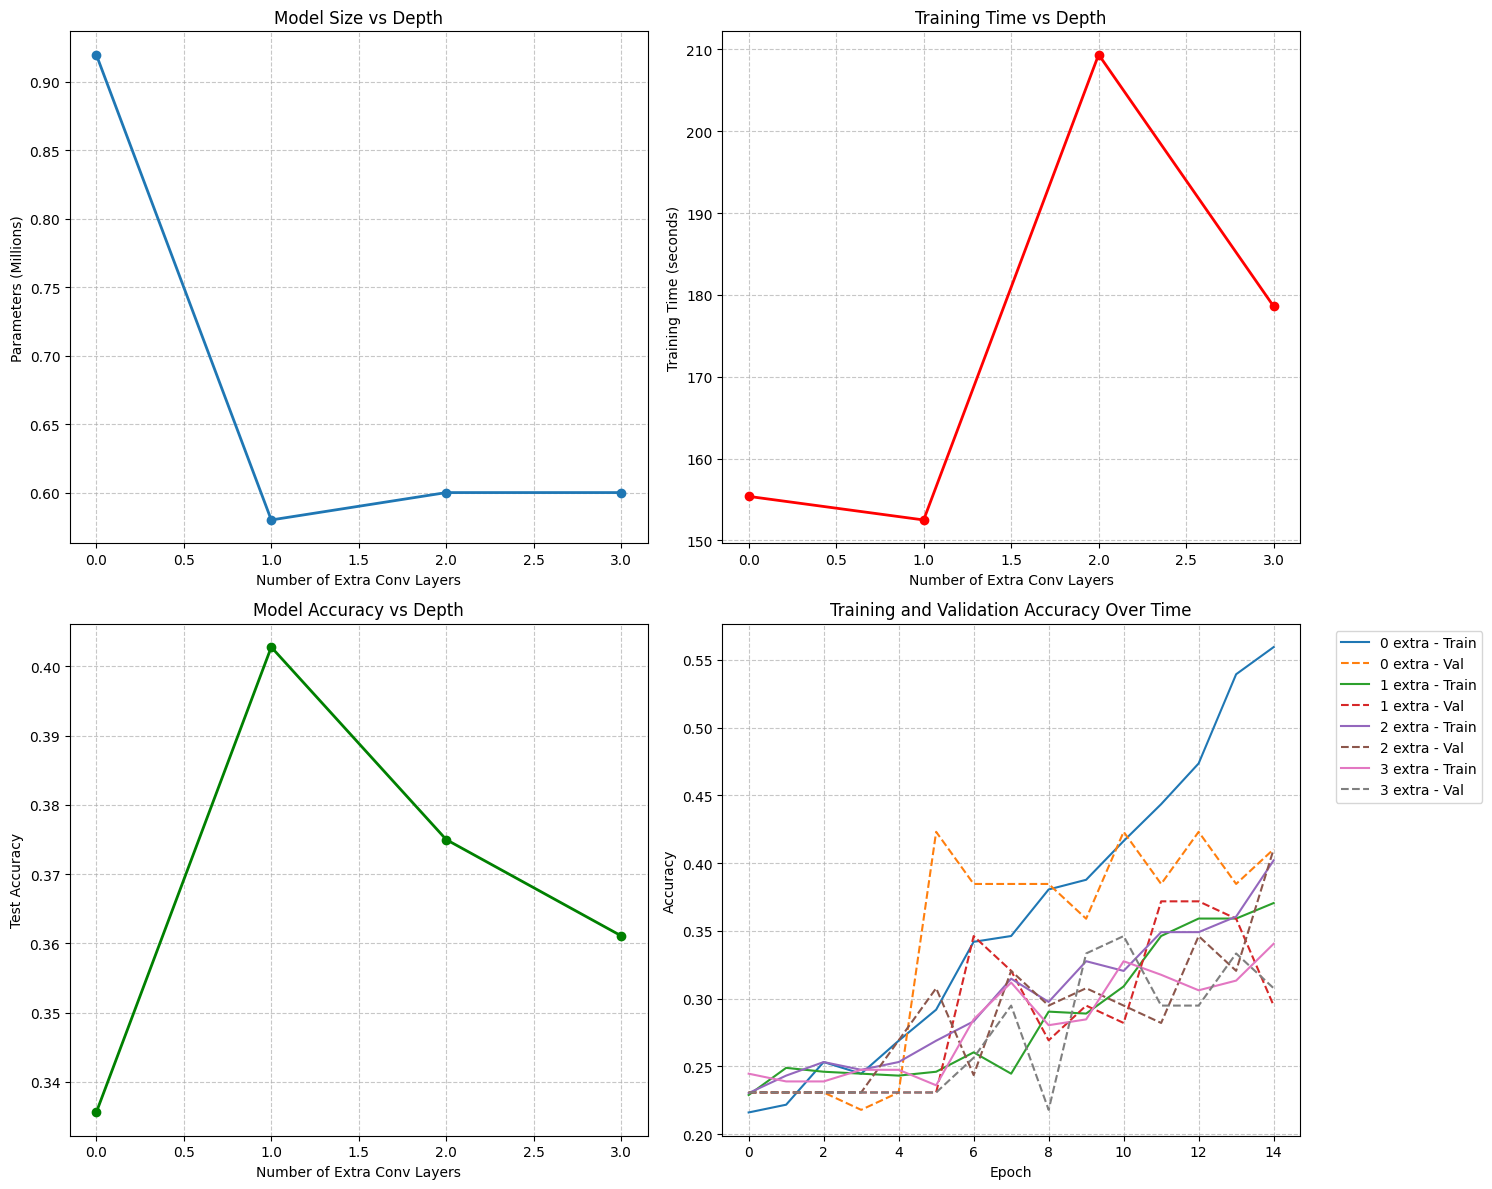

In [60]:
# ******************** Visualization Code ********************

def plot_depth_results(results, history_list):
    """Generate visualizations for model depth experiment results"""
    # Display results table
    df_results = pd.DataFrame(results)
    table = tabulate(df_results, headers='keys', tablefmt='fancy_grid',
                    showindex=False)
    print("\nModel Depth Comparison Results:\n", table)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Parameters vs Extra Layers
    x = [r["Extra Conv Layers"] for r in results]
    ax1.plot(x, [r["Params (Millions)"] for r in results],
            marker='o', linewidth=2)
    ax1.set_xlabel('Number of Extra Conv Layers')
    ax1.set_ylabel('Parameters (Millions)')
    ax1.set_title('Model Size vs Depth')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Training Time vs Extra Layers
    ax2.plot(x, [r["Training Time (s)"] for r in results],
             marker='o', linewidth=2, color='red')
    ax2.set_xlabel('Number of Extra Conv Layers')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.set_title('Training Time vs Depth')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Accuracy vs Extra Layers
    ax3.plot(x, [r["Test Accuracy"] for r in results],
             marker='o', linewidth=2, color='green')
    ax3.set_xlabel('Number of Extra Conv Layers')
    ax3.set_ylabel('Test Accuracy')
    ax3.set_title('Model Accuracy vs Depth')
    ax3.grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Training History
    for i, history in enumerate(history_list):
        extra_layers = results[i]["Extra Conv Layers"]
        ax4.plot(history['accuracy'],
                label=f'{extra_layers} extra - Train')
        ax4.plot(history['val_accuracy'], linestyle='--',
                label=f'{extra_layers} extra - Val')

    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Training and Validation Accuracy Over Time')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Run the experiment
try:
    results, history_list = run_depth_experiment(X_train_gray, y_train,
                                               X_test_gray, y_test)
    plot_depth_results(results, history_list)
except Exception as e:
    print(f"An error occurred: {str(e)}")

# FINAL

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, AveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_final_model():
    model = Sequential()

    # Base configuration from best results
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # Input layer
    model.add(Conv2D(filters[0], kernel_size=conv_kernels[0], padding='same', input_shape=(80, 80, 1)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Additional conv layers
    for i in range(1, len(conv_kernels)):
        model.add(Conv2D(filters[i], kernel_size=conv_kernels[i], padding='same'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(BatchNormalization())
        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    for _ in range(3):
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.25))

    # Output layer
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the model
model = build_final_model()


In [100]:
# Print the sizes of train and test datasets
print(f"Training set images shape: {X_train_gray.shape}")
print(f"Training set labels shape: {y_train.shape}")
print(f"Test set images shape: {X_test_gray.shape}")
print(f"Test set labels shape: {y_test.shape}")


Training set images shape: (777, 80, 80, 1)
Training set labels shape: (777,)
Test set images shape: (432, 80, 80, 1)
Test set labels shape: (432,)


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 966ms/step - accuracy: 0.2289 - loss: 1.8265 - val_accuracy: 0.3125 - val_loss: 1.6042
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 973ms/step - accuracy: 0.2838 - loss: 1.6735 - val_accuracy: 0.1991 - val_loss: 1.6068
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 856ms/step - accuracy: 0.3712 - loss: 1.5060 - val_accuracy: 0.1991 - val_loss: 1.6259
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 954ms/step - accuracy: 0.3775 - loss: 1.4694 - val_accuracy: 0.2014 - val_loss: 1.6503
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 878ms/step - accuracy: 0.4613 - loss: 1.3414 - val_accuracy: 0.2014 - val_loss: 1.7753
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 988ms/step - accuracy: 0.4516 - loss: 1.3325 - val_accuracy: 0.2014 - val_loss: 1.8293
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 812ms/step - accuracy: 0.4778 - loss: 1.2618 - val_accuracy: 0.2014 - val_loss: 1.9279
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 987ms/step - accuracy: 0.5189 - loss: 1.1919 - val_accu

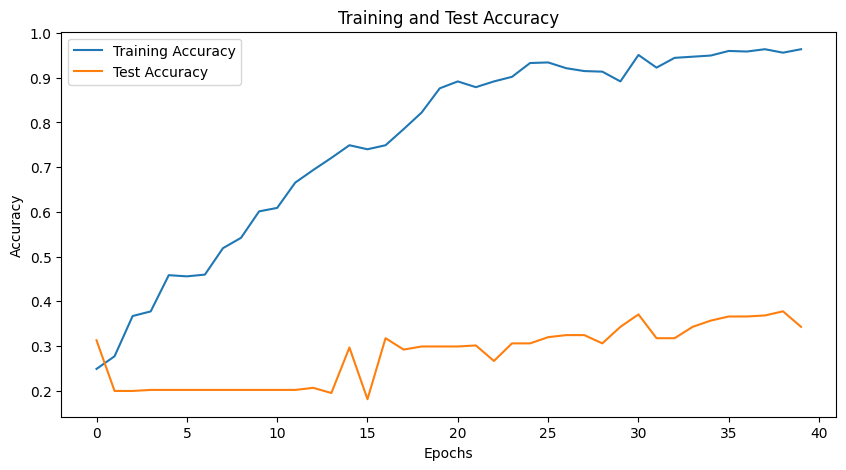

In [101]:
# Build the final model
model = build_final_model()

# Train the model
history = model.fit(X_train_gray, y_train, epochs=40, batch_size=64, validation_data=(X_test_gray, y_test))

# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


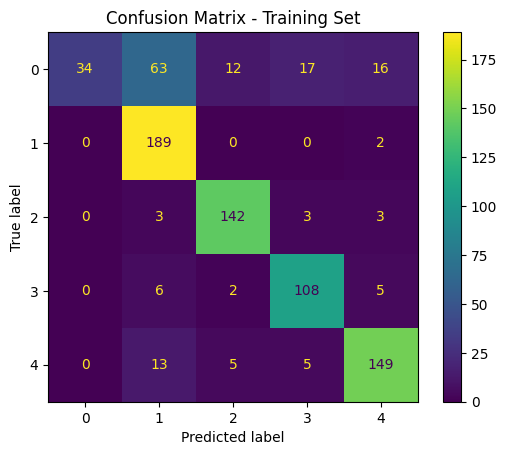

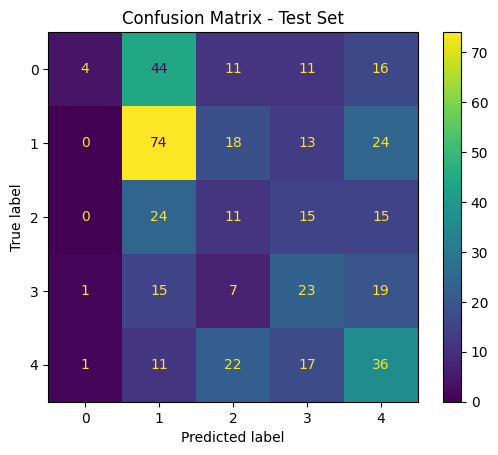

Weighted F1 Score on Training Set: 0.7699
Weighted F1 Score on Test Set: 0.3125


In [102]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# Predictions on the training and test sets
y_train_pred = np.argmax(model.predict(X_train_gray), axis=1)
y_test_pred = np.argmax(model.predict(X_test_gray), axis=1)

# Confusion Matrix for training set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train).plot()
plt.title("Confusion Matrix - Training Set")
plt.show()

# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test).plot()
plt.title("Confusion Matrix - Test Set")
plt.show()

# F1 Score for training and test sets
f1_train = f1_score(y_train, y_train_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print(f"Weighted F1 Score on Training Set: {f1_train:.4f}")
print(f"Weighted F1 Score on Test Set: {f1_test:.4f}")


# **Now checking accuracy of the colored images through final model**

# **before that we need to change the final code input image dimension so that it can support RGB color images**

In [104]:
print("Training set size GREY (after reduction):", X_train_gray.shape)
print("Test set size GREY:", X_test_gray.shape)

print("\nTraining set size COLOR (after reduction):", X_train.shape)
print("Test set size COLOR:", X_test.shape)

Training set size GREY (after reduction): (777, 80, 80, 1)
Test set size GREY: (432, 80, 80, 1)

Training set size COLOR (after reduction): (777, 80, 80, 3)
Test set size COLOR: (432, 80, 80, 3)


In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, AveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_final_model_RGB():
    model_RGB_FINAL = Sequential()

    # Base configuration from best results
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # Input layer
    # Changed input_shape from (80, 80, 1) to (80, 80, 3) to match color images
    model_RGB_FINAL.add(Conv2D(filters[0], kernel_size=conv_kernels[0], padding='same', input_shape=(80, 80, 3)))
    model_RGB_FINAL.add(LeakyReLU(alpha=0.01))
    model_RGB_FINAL.add(BatchNormalization())
    model_RGB_FINAL.add(AveragePooling2D(pool_size=(2, 2)))
    model_RGB_FINAL.add(Dropout(0.25))

    # Additional conv layers
    for i in range(1, len(conv_kernels)):
        model_RGB_FINAL.add(Conv2D(filters[i], kernel_size=conv_kernels[i], padding='same'))
        model_RGB_FINAL.add(LeakyReLU(alpha=0.01))
        model_RGB_FINAL.add(BatchNormalization())
        model_RGB_FINAL.add(AveragePooling2D(pool_size=(2, 2)))
        model_RGB_FINAL.add(Dropout(0.25))

    # Flatten layer
    model_RGB_FINAL.add(Flatten())

    # Fully connected layers
    for _ in range(3):
        model_RGB_FINAL.add(Dense(128))
        model_RGB_FINAL.add(LeakyReLU(alpha=0.01))
        model_RGB_FINAL.add(Dropout(0.25))

    # Output layer
    model_RGB_FINAL.add(Dense(5, activation='softmax'))

    # Compile model
    model_RGB_FINAL.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model_RGB_FINAL



In [106]:
# Build the final model
model_RGB_FINAL = build_final_model_RGB()

# Train the model
history = model_RGB_FINAL.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2855 - loss: 1.6979 - val_accuracy: 0.2384 - val_loss: 1.8066
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4560 - loss: 1.4066 - val_accuracy: 0.3009 - val_loss: 1.6103
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5201 - loss: 1.2966 - val_accuracy: 0.3056 - val_loss: 1.5320
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 886ms/step - accuracy: 0.5038 - loss: 1.2952 - val_accuracy: 0.2940 - val_loss: 1.4975
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5356 - loss: 1.1955 - val_accuracy: 0.3796 - val_loss: 1.3517
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5755 - loss: 1.0680 - val_accuracy: 0.3819 - val_loss: 1.4536
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 833ms/step - accuracy: 0.5521 - loss: 1.1099 - val_accuracy: 0.3750 - val_loss: 1.4294
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5985 - loss: 0.9887 - val_accuracy: 0.4977 - val

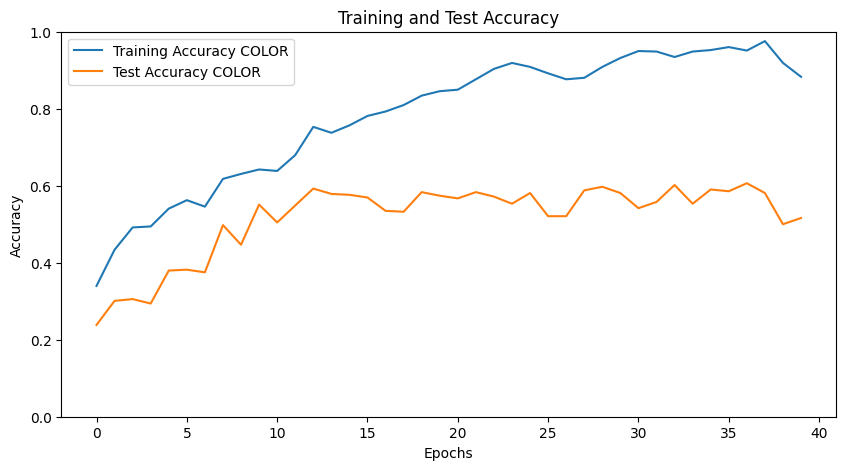

In [107]:
# Plot training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy COLOR')
plt.plot(history.history['val_accuracy'], label='Test Accuracy COLOR')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()

# confusion matrix and f1-score for RGB images

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step


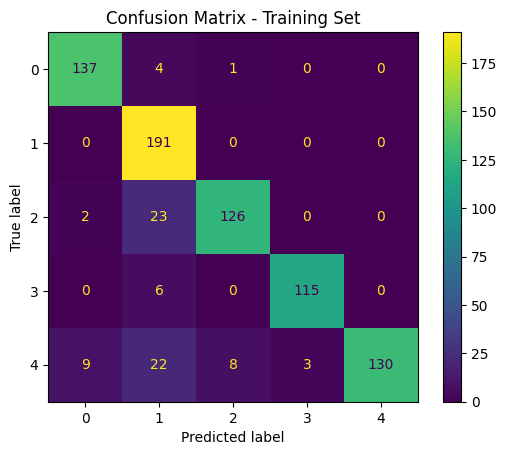

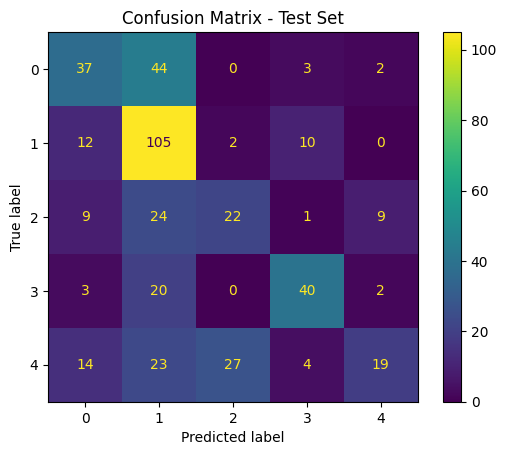

Weighted F1 Score on Training Set: 0.7699
Weighted F1 Score on Test Set: 0.3125


In [108]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# Predictions on the training and test sets
y_train_pred_COLOR = np.argmax(model_RGB_FINAL.predict(X_train), axis=1)
y_test_pred_COLOR = np.argmax(model_RGB_FINAL.predict(X_test), axis=1)

# Confusion Matrix for training set
conf_matrix_train_COLOR = confusion_matrix(y_train, y_train_pred_COLOR)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train_COLOR).plot()
plt.title("Confusion Matrix - Training Set")
plt.show()

# Confusion Matrix for test set
conf_matrix_test_COLOR = confusion_matrix(y_test, y_test_pred_COLOR)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test_COLOR).plot()
plt.title("Confusion Matrix - Test Set")
plt.show()

# F1 Score for training and test sets
f1_train_COLOR = f1_score(y_train, y_train_pred_COLOR, average='weighted')
f1_test_COLOR = f1_score(y_test, y_test_pred_COLOR, average='weighted')
print(f"Weighted F1 Score on Training Set: {f1_train:.4f}")
print(f"Weighted F1 Score on Test Set: {f1_test:.4f}")


# **NOW WE WILL BE CHECKING MNSIT DATASET USING OUR FINAL GREYSCALE MODEL**

In [109]:
from tensorflow.keras.datasets import mnist

In [110]:
# Load and preprocess the MNIST dataset
(X_train_MNIST, y_train_MNIST), (X_test_MNIST, y_test_MNIST) = mnist.load_data()


# Print the original dimensions of the dataset
print("Original X_train_MNIST shape:", X_train_MNIST.shape)
print("Original X_test_MNIST shape:", X_test_MNIST.shape)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original X_train_MNIST shape: (60000, 28, 28)
Original X_test_MNIST shape: (10000, 28, 28)


In [111]:
# Normalize the images to a range of [0, 1] and reshape to (80, 80, 1) for grayscale input
X_train_MNIST = np.array([np.expand_dims(np.resize(img, (80, 80)), axis=-1) for img in X_train_MNIST]) / 255.0
X_test_MNIST = np.array([np.expand_dims(np.resize(img, (80, 80)), axis=-1) for img in X_test_MNIST]) / 255.0

In [112]:
# Reduction factor 'p'
p = 10
X_train_MNIST = X_train_MNIST[:len(X_train_MNIST) // p]
y_train_MNIST = y_train_MNIST[:len(y_train_MNIST) // p]
X_test_MNIST = X_test_MNIST[:len(X_test_MNIST) // p]
y_test_MNIST = y_test_MNIST[:len(y_test_MNIST) // p]

# Print the dimensions of the reduced dataset
print("Reduced X_train_MNIST shape:", X_train_MNIST.shape)
print("Reduced X_test_MNIST shape:", X_test_MNIST.shape)

Reduced X_train_MNIST shape: (6000, 80, 80, 1)
Reduced X_test_MNIST shape: (1000, 80, 80, 1)


## **since our prev final model for greyscale images had only 5 output layers bit here we need 10 for digits 0-9 , hence for MNSIT only , we will slightly change the model to a model with 10 output layers , rest specs are kept unchanged**

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, AveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_final_model():
    model_FINAL_GREYSCALE_MNSIT = Sequential()

    # Base configuration from best results
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # Input layer
    model_FINAL_GREYSCALE_MNSIT.add(Conv2D(filters[0], kernel_size=conv_kernels[0], padding='same', input_shape=(80, 80, 1)))
    model_FINAL_GREYSCALE_MNSIT.add(LeakyReLU(alpha=0.01))
    model_FINAL_GREYSCALE_MNSIT.add(BatchNormalization())
    model_FINAL_GREYSCALE_MNSIT.add(AveragePooling2D(pool_size=(2, 2)))
    model_FINAL_GREYSCALE_MNSIT.add(Dropout(0.25))

    # Additional conv layers
    for i in range(1, len(conv_kernels)):
        model_FINAL_GREYSCALE_MNSIT.add(Conv2D(filters[i], kernel_size=conv_kernels[i], padding='same'))
        model_FINAL_GREYSCALE_MNSIT.add(LeakyReLU(alpha=0.01))
        model_FINAL_GREYSCALE_MNSIT.add(BatchNormalization())
        model_FINAL_GREYSCALE_MNSIT.add(AveragePooling2D(pool_size=(2, 2)))
        model_FINAL_GREYSCALE_MNSIT.add(Dropout(0.25))

    # Flatten layer
    model_FINAL_GREYSCALE_MNSIT.add(Flatten())

    # Fully connected layers
    for _ in range(3):
        model_FINAL_GREYSCALE_MNSIT.add(Dense(128))
        model_FINAL_GREYSCALE_MNSIT.add(LeakyReLU(alpha=0.01))
        model_FINAL_GREYSCALE_MNSIT.add(Dropout(0.25))

    # Output layer with 10 OUTPUT LAYER FOR MNSIT
    model_FINAL_GREYSCALE_MNSIT.add(Dense(10, activation='softmax'))

    # Compile model
    model_FINAL_GREYSCALE_MNSIT.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model_FINAL_GREYSCALE_MNSIT


In [121]:
import time

# Build and train the model
model_FINAL_GREYSCALE_MNSIT = build_final_model()



start_time_epoch = time.time()
history = model_FINAL_GREYSCALE_MNSIT.fit(X_train_MNIST, y_train_MNIST, epochs=15, validation_data=(X_test_MNIST, y_test_MNIST))
total_duration = time.time() - start_time_epoch



# Final accuracy and loss on validation set
final_loss, final_accuracy = model_FINAL_GREYSCALE_MNSIT.evaluate(X_test_MNIST, y_test_MNIST, verbose=0)
# Print total time and final metrics
print(f"\nTotal training time: {total_duration:.2f} seconds")
print(f"Final validation accuracy: {final_accuracy:.4f}")
print(f"Final validation loss: {final_loss:.4f}")

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 464ms/step - accuracy: 0.5544 - loss: 1.2909 - val_accuracy: 0.0850 - val_loss: 3.6016
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 140s 453ms/step - accuracy: 0.9087 - loss: 0.3116 - val_accuracy: 0.0910 - val_loss: 10.6458
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 85s 452ms/step - accuracy: 0.9441 - loss: 0.1878 - val_accuracy: 0.7020 - val_loss: 1.2875
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 141s 447ms/step - accuracy: 0.9435 - loss: 0.2053 - val_accuracy: 0.8650 - val_loss: 0.5600
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 447ms/step - accuracy: 0.9594 - loss: 0.1375 - val_accuracy: 0.9470 - val_loss: 0.1675
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 460ms/step - accuracy: 0.9663 - loss: 0.1141 - val_accuracy: 0.9700 - val_loss: 0.1121
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 140s 449ms/step - accuracy: 0.9706 - loss: 0.1035 - val_accuracy: 0.9650 - val_loss: 0.1400
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 147s 472ms/step - accuracy: 0.9711 - lo

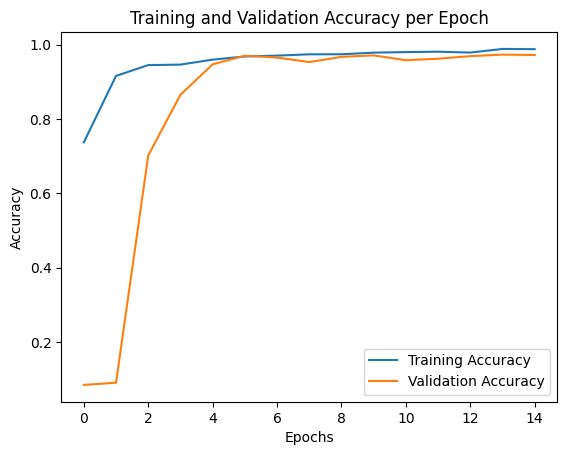

In [122]:
# Plot accuracy for training and testing over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy per Epoch")
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step


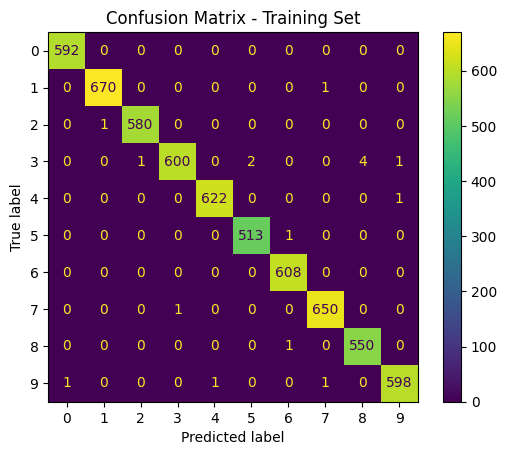

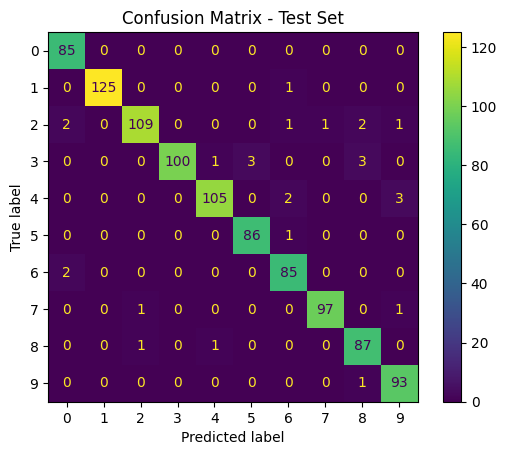

Weighted F1 Score on Training Set: 0.9972
Weighted F1 Score on Test Set: 0.9720


In [123]:
# Confusion matrix and F1 score
# Predictions on the training and test sets
y_train_pred_MNIST = np.argmax(model_FINAL_GREYSCALE_MNSIT.predict(X_train_MNIST), axis=1)
y_test_pred_MNIST = np.argmax(model_FINAL_GREYSCALE_MNSIT.predict(X_test_MNIST), axis=1)

# Confusion Matrix for training set
conf_matrix_train_MNIST = confusion_matrix(y_train_MNIST, y_train_pred_MNIST)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train_MNIST).plot()
plt.title("Confusion Matrix - Training Set")
plt.show()

# Confusion Matrix for test set
conf_matrix_test_MNIST = confusion_matrix(y_test_MNIST, y_test_pred_MNIST)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test_MNIST).plot()
plt.title("Confusion Matrix - Test Set")
plt.show()

# F1 Score for training and test sets
f1_train_MNIST = f1_score(y_train_MNIST, y_train_pred_MNIST, average='weighted')
f1_test_MNIST = f1_score(y_test_MNIST, y_test_pred_MNIST, average='weighted')
print(f"Weighted F1 Score on Training Set: {f1_train_MNIST:.4f}")
print(f"Weighted F1 Score on Test Set: {f1_test_MNIST:.4f}")

## **this is same MNSIT model with changed input shape to '28*28'**

In [148]:
from tensorflow.keras.datasets import mnist

# Load and preprocess the MNIST dataset
(X_train_MNIST_0, y_train_MNIST_0), (X_test_MNIST_0, y_test_MNIST_0) = mnist.load_data()


# Print the original dimensions of the dataset
print("Original X_train_MNIST shape:", X_train_MNIST_0.shape)
print("Original X_test_MNIST shape:", X_test_MNIST_0.shape)


Original X_train_MNIST shape: (60000, 28, 28)
Original X_test_MNIST shape: (10000, 28, 28)


In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, AveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_final_model_MNSIT_28():
    model_FINAL_GREYSCALE_MNSIT_2 = Sequential()

    # Base configuration from best results
    conv_kernels = [(3, 3), (5, 5), (5, 5)]
    filters = [16, 32, 64]

    # Input layer
    model_FINAL_GREYSCALE_MNSIT_2.add(Conv2D(filters[0], kernel_size=conv_kernels[0], padding='same', input_shape=(28, 28, 1)))
    model_FINAL_GREYSCALE_MNSIT_2.add(LeakyReLU(alpha=0.01))
    model_FINAL_GREYSCALE_MNSIT_2.add(BatchNormalization())
    model_FINAL_GREYSCALE_MNSIT_2.add(AveragePooling2D(pool_size=(2, 2)))
    model_FINAL_GREYSCALE_MNSIT_2.add(Dropout(0.25))

    # Additional conv layers
    for i in range(1, len(conv_kernels)):
        model_FINAL_GREYSCALE_MNSIT_2.add(Conv2D(filters[i], kernel_size=conv_kernels[i], padding='same'))
        model_FINAL_GREYSCALE_MNSIT_2.add(LeakyReLU(alpha=0.01))
        model_FINAL_GREYSCALE_MNSIT_2.add(BatchNormalization())
        model_FINAL_GREYSCALE_MNSIT_2.add(AveragePooling2D(pool_size=(2, 2)))
        model_FINAL_GREYSCALE_MNSIT_2.add(Dropout(0.25))

    # Flatten layer
    model_FINAL_GREYSCALE_MNSIT_2.add(Flatten())

    # Fully connected layers
    for _ in range(3):
        model_FINAL_GREYSCALE_MNSIT_2.add(Dense(128))
        model_FINAL_GREYSCALE_MNSIT_2.add(LeakyReLU(alpha=0.01))
        model_FINAL_GREYSCALE_MNSIT_2.add(Dropout(0.25))

    # Output layer with 10 OUTPUT LAYER FOR MNSIT
    model_FINAL_GREYSCALE_MNSIT_2.add(Dense(10, activation='softmax'))

    # Compile model
    model_FINAL_GREYSCALE_MNSIT_2.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model_FINAL_GREYSCALE_MNSIT_2


## WE WILL RUN IT ON FULL MNSIT DATASET , NO REDUCTION !!

In [151]:
import time

# Build and train the model
model_FINAL_GREYSCALE_MNSIT_2 = build_final_model_MNSIT_28()



start_time_epoch = time.time()
history = model_FINAL_GREYSCALE_MNSIT_2.fit(X_train_MNIST_0, y_train_MNIST_0, epochs=5, validation_data=(X_test_MNIST_0, y_test_MNIST_0))
total_duration = time.time() - start_time_epoch



# Final accuracy and loss on validation set
final_loss, final_accuracy = model_FINAL_GREYSCALE_MNSIT_2.evaluate(X_test_MNIST_0, y_test_MNIST_0, verbose=0)
# Print total time and final metrics
print(f"\nTotal training time: {total_duration:.2f} seconds")
print(f"Final validation accuracy: {final_accuracy:.4f}")
print(f"Final validation loss: {final_loss:.4f}")

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 128s 66ms/step - accuracy: 0.8546 - loss: 0.4510 - val_accuracy: 0.9862 - val_loss: 0.0457
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 126s 67ms/step - accuracy: 0.9720 - loss: 0.1019 - val_accuracy: 0.9879 - val_loss: 0.0444
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 66ms/step - accuracy: 0.9777 - loss: 0.0817 - val_accuracy: 0.9894 - val_loss: 0.0367
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - accuracy: 0.9802 - loss: 0.0693 - val_accuracy: 0.9895 - val_loss: 0.0368
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 66ms/step - accuracy: 0.9835 - loss: 0.0621 - val_accuracy: 0.9900 - val_loss: 0.0339

Total training time: 695.52 seconds
Final validation accuracy: 0.9900
Final validation loss: 0.0339


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


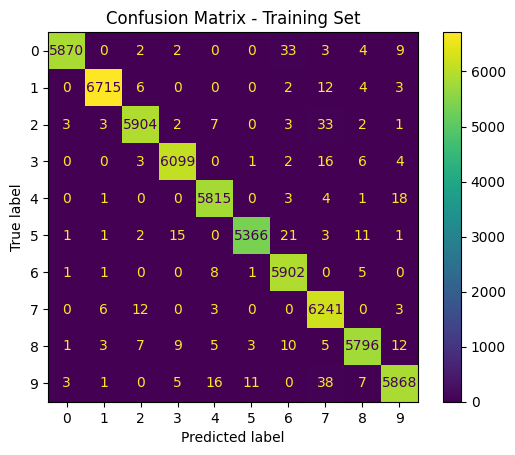

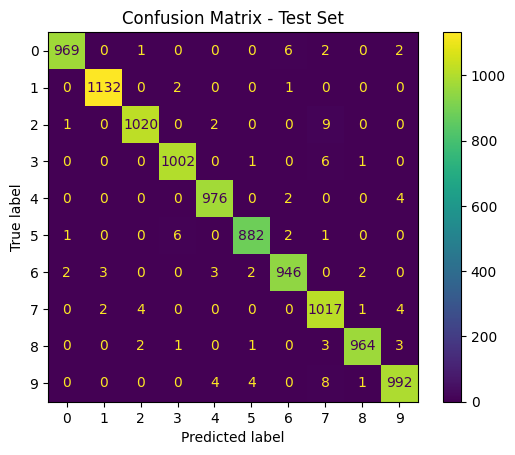

Weighted F1 Score on Training Set: 0.9929
Weighted F1 Score on Test Set: 0.9900


In [160]:
# Confusion matrix and F1 score
# Predictions on the training and test sets
y_train_pred_MNIST_2 = np.argmax(model_FINAL_GREYSCALE_MNSIT_2.predict(X_train_MNIST_0), axis=1)
y_test_pred_MNIST_2 = np.argmax(model_FINAL_GREYSCALE_MNSIT_2.predict(X_test_MNIST_0), axis=1)

# Confusion Matrix for training set
conf_matrix_train_MNIST_2 = confusion_matrix(y_train_MNIST_0, y_train_pred_MNIST_2)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train_MNIST_2).plot()
plt.title("Confusion Matrix - Training Set")
plt.show()

# Confusion Matrix for test set
conf_matrix_test_MNIST_2 = confusion_matrix(y_test_MNIST_0, y_test_pred_MNIST_2)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test_MNIST_2).plot()
plt.title("Confusion Matrix - Test Set")
plt.show()

# F1 Score for training and test sets
f1_train_MNIST_2 = f1_score(y_train_MNIST_0, y_train_pred_MNIST_2, average='weighted')
f1_test_MNIST_2 = f1_score(y_test_MNIST_0, y_test_pred_MNIST_2, average='weighted')
print(f"Weighted F1 Score on Training Set: {f1_train_MNIST_2:.4f}")
print(f"Weighted F1 Score on Test Set: {f1_test_MNIST_2:.4f}")

# **NOW CHECKING HANDWRITTEN IMAGES**

In [158]:
import os
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential  # Assuming model is defined as in prior context

# Upload files
uploaded = files.upload()

# Save uploaded files to a folder
image_folder = "uploaded_images"
os.makedirs(image_folder, exist_ok=True)
for file_name in uploaded.keys():
    with open(os.path.join(image_folder, file_name), "wb") as f:
        f.write(uploaded[file_name])

# Define function to process images
def process_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')  # Convert to grayscale
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.show()

    img = img.resize((28, 28))  # Resize to 28x28 to match model input
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = img_array.reshape(1, 28, 28, 1)  # Reshape for model input

    # Show resized image
    plt.imshow(img, cmap='gray')
    plt.title("Resized Image (28x28)")
    plt.show()

    return img_array




Saving 1.jfif to 1.jfif
Saving 2.jfif to 2.jfif
Saving 3.jfif to 3.jfif
Saving 4.jfif to 4.jfif
Saving 5.jfif to 5.jfif
Saving 6.jfif to 6.jfif
Saving 7.jfif to 7.jfif
Saving 8.jfif to 8.jfif
Saving 9.jfif to 9.jfif
Saving 0.jfif to 0.jfif


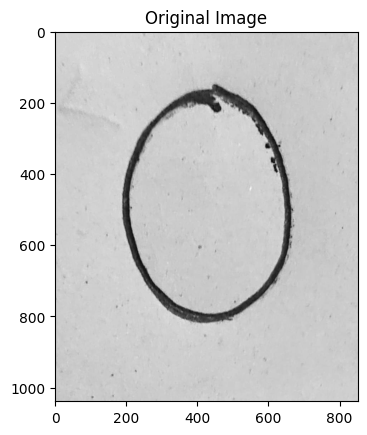

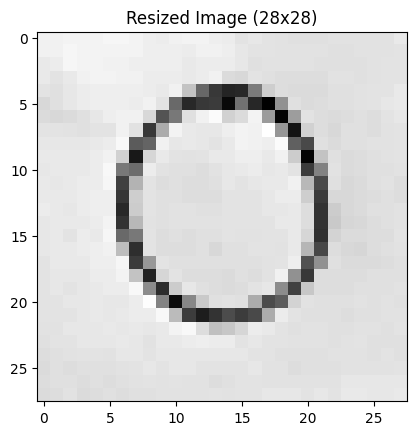

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: 0.jfif, Predicted Digit: 1


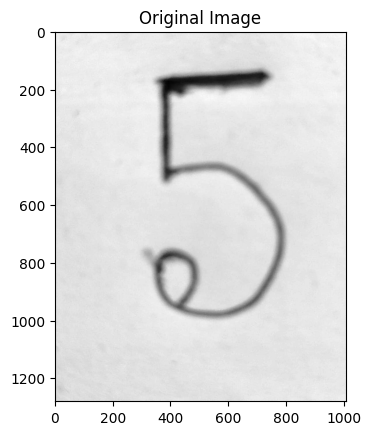

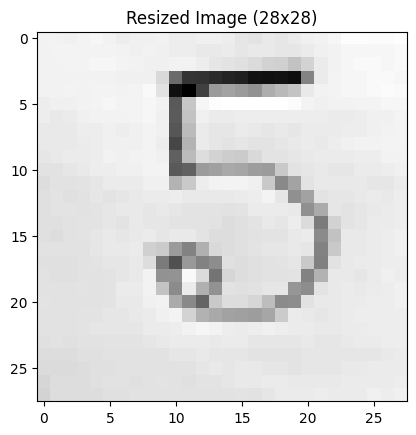

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 5.jfif, Predicted Digit: 1


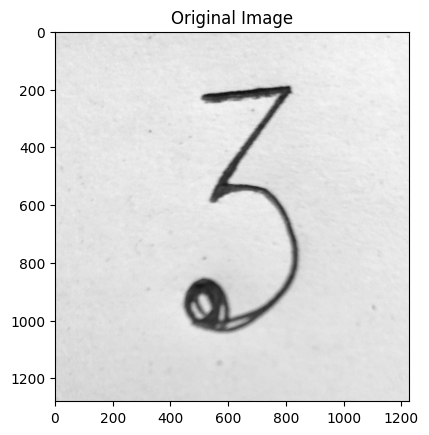

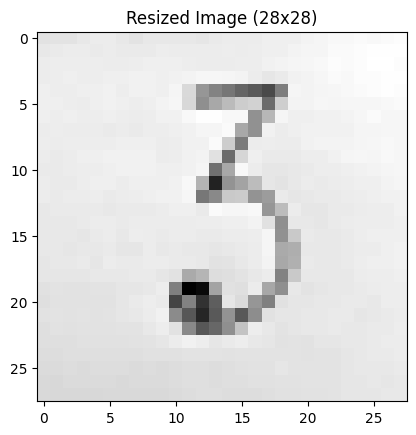

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: 3.jfif, Predicted Digit: 1


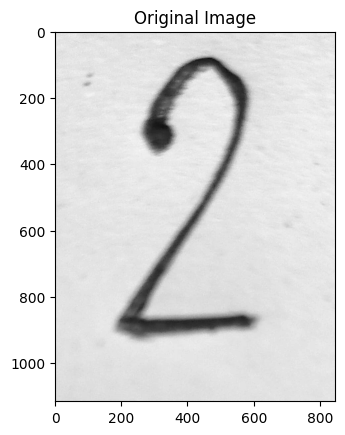

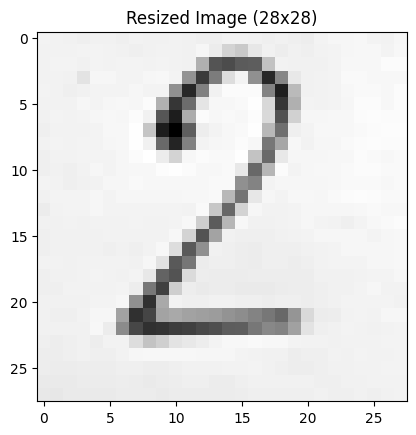

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: 2.jfif, Predicted Digit: 1


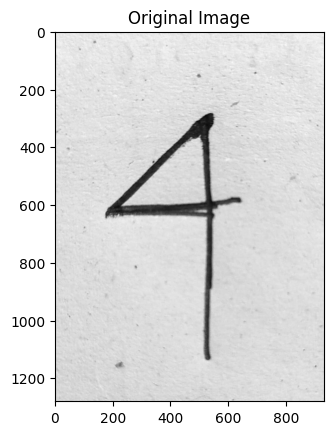

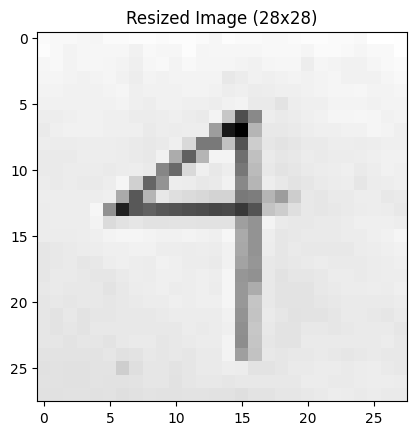

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: 4.jfif, Predicted Digit: 1


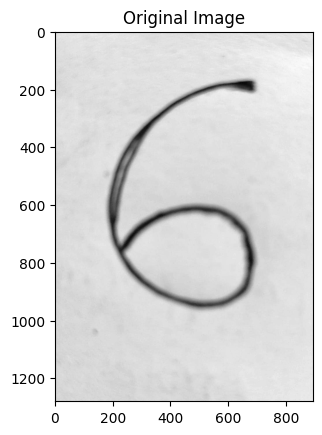

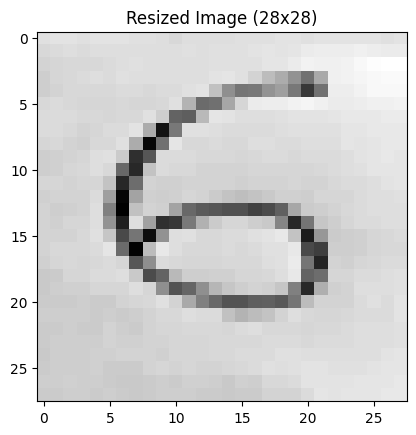

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: 6.jfif, Predicted Digit: 1


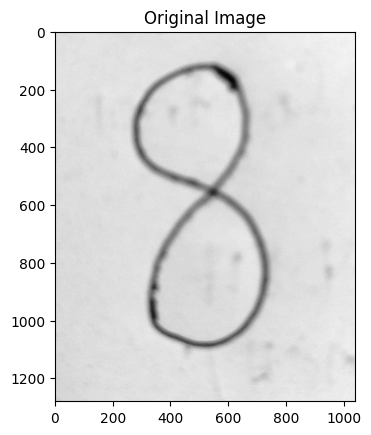

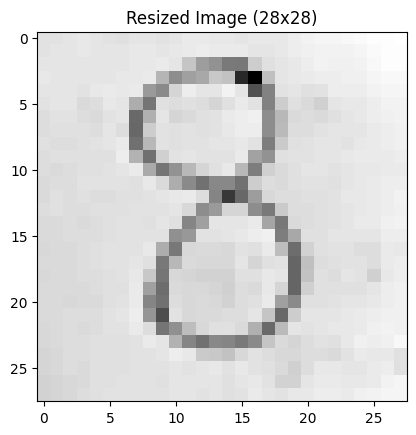

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: 8.jfif, Predicted Digit: 1


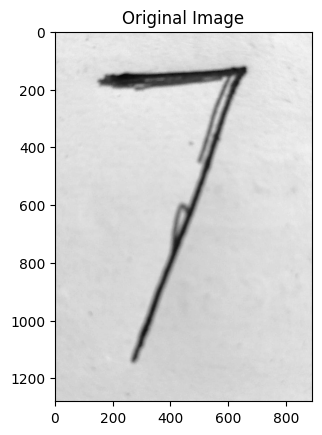

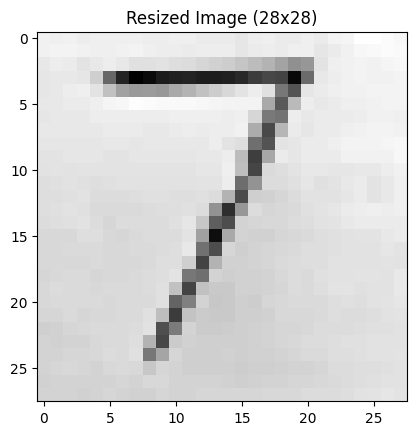

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: 7.jfif, Predicted Digit: 1


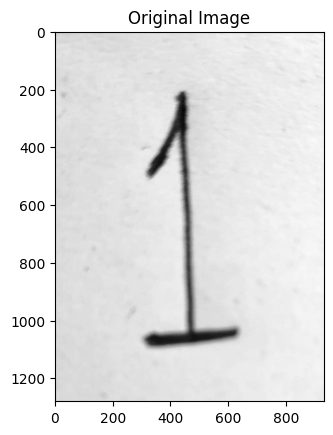

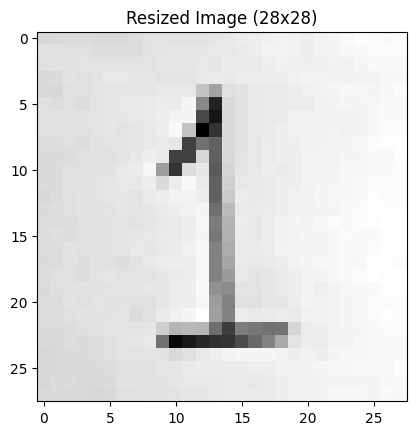

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 1.jfif, Predicted Digit: 1


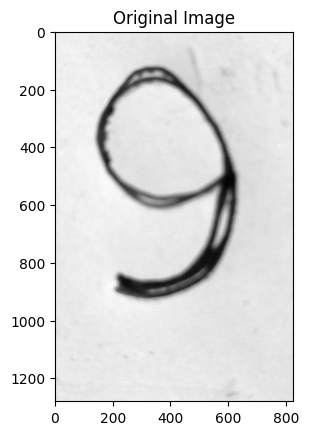

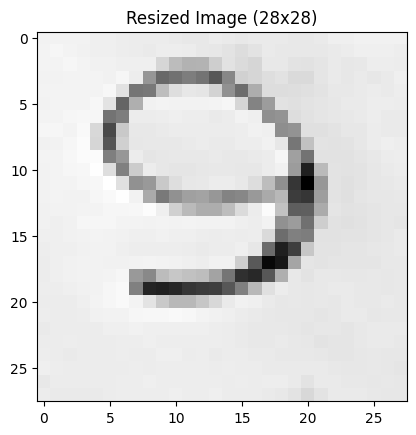

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: 9.jfif, Predicted Digit: 1


In [159]:
# Model prediction
predictions = {}
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    # Skip directories or non-image files
    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif')):
        continue

    # Process image and predict
    img_array = process_image(image_path)
    prediction = model_FINAL_GREYSCALE_MNSIT_2.predict(img_array)
    predicted_digit = np.argmax(prediction)

    # Store and display prediction
    predictions[image_name] = predicted_digit
    print(f"Image: {image_name}, Predicted Digit: {predicted_digit}")



In [157]:
# Clear the folder after execution
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove file or link
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

print("Directory cleared successfully.")

Directory cleared successfully.
